In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [4]:
def parse_log_file(file_path):
    data = []
    
    # Buffer to hold validation metrics (HellaSwag/Val Loss) 
    # until we hit the corresponding step line
    validation_buffer = {}
    temp_hellaswag = None

    # Regex patterns
    # Matches: step 1903 | loss: 4.0717 | lr: 5.943e-04 ...
    step_pattern = re.compile(
        r"step (\d+) \| loss: ([\d.]+) \| lr: ([\d.e-]+) \| norm: ([\d.]+) \| time: ([\d.]+) ms \| tokens/sec: ([\d.]+)"
    )
    
    # Matches: HellaSwag accuracy: ... = 0.2568
    hellaswag_pattern = re.compile(r"HellaSwag accuracy:.*?=([\d.]+)")
    
    # Matches: validation loss at step 1907: 4.0385
    val_loss_pattern = re.compile(r"validation loss at step (\d+): ([\d.]+)")

    try:
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                
                # 1. Check for Main Step Line
                step_match = step_pattern.search(line)
                if step_match:
                    step = int(step_match.group(1))
                    row = {
                        'step': step,
                        'loss': float(step_match.group(2)),
                        'lr': float(step_match.group(3)),
                        'norm': float(step_match.group(4)),
                        'time_ms': float(step_match.group(5)),
                        'tokens_sec': float(step_match.group(6)),
                        'hella_swag_acc': None,
                        'val_loss': None
                    }
                    
                    # Merge if we have buffered validation data for this step
                    if step in validation_buffer:
                        row.update(validation_buffer[step])
                        del validation_buffer[step] # Clean up used buffer
                    
                    data.append(row)
                    continue

                # 2. Check for Validation Loss Line
                val_match = val_loss_pattern.search(line)
                if val_match:
                    val_step = int(val_match.group(1))
                    val_loss = float(val_match.group(2))
                    
                    if val_step not in validation_buffer:
                        validation_buffer[val_step] = {}
                    
                    validation_buffer[val_step]['val_loss'] = val_loss
                    
                    # Attach previously seen HellaSwag score to this step
                    if temp_hellaswag is not None:
                        validation_buffer[val_step]['hella_swag_acc'] = temp_hellaswag
                        temp_hellaswag = None
                    continue

                # 3. Check for HellaSwag Line
                hella_match = hellaswag_pattern.search(line)
                if hella_match:
                    temp_hellaswag = float(hella_match.group(1))
                    continue

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return pd.DataFrame()

    return pd.DataFrame(data)


df = parse_log_file('my_log.txt')

In [5]:
df

,step,loss,lr,norm,time_ms,tokens_sec,hella_swag_acc,val_loss
0,0,10.9565,8.571000e-07,3.3472,33402.34,15696.15,0.2527,10.9556
1,1,10.9417,1.714000e-06,3.2503,1567.17,334545.12,NaN,NaN
2,2,10.9200,2.571000e-06,3.2227,1566.37,334715.60,NaN,NaN
3,3,10.8857,3.429000e-06,3.2334,1567.13,334553.46,NaN,NaN
4,4,10.8407,4.286000e-06,3.2184,1567.86,334397.08,NaN,NaN
...,...,...,...,...,...,...,...,...
19068,19068,3.4146,6.000000e-05,0.3081,1578.51,332141.41,NaN,NaN
19069,19069,3.3906,6.000000e-05,0.3197,1579.64,331903.64,NaN,NaN
19070,19070,3.4260,6.000000e-05,0.3152,32815.28,15976.95,0.2924,3.3596
19071,19071,3.3541,6.000000e-05,0.3049,1575.22,332835.76,NaN,NaN


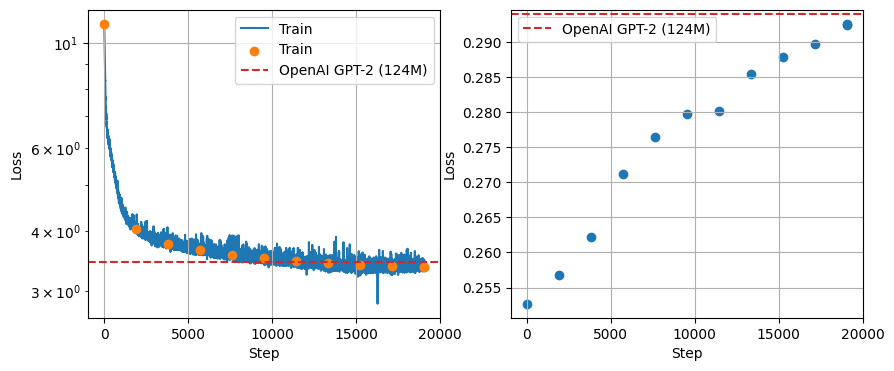

In [21]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].plot(df['step'], df['loss'], label='Train', zorder=1)
ax[0].scatter(df[~df['val_loss'].isna()]['step'], df[~df['val_loss'].isna()]['val_loss'], c='tab:orange', label='Train', zorder=2)
ax[0].axhline(3.44, linestyle='--', c='tab:red', label='OpenAI GPT-2 (124M)')
ax[0].grid('on')
ax[0].set_yscale('log')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].scatter(df[~df['hella_swag_acc'].isna()]['step'], df[~df['hella_swag_acc'].isna()]['hella_swag_acc'], c='tab:blue', zorder=1)
ax[1].axhline(0.294, linestyle='--', c='tab:red', label='OpenAI GPT-2 (124M)')
ax[1].grid('on')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Loss')
ax[1].legend()